## Import libraries

In [1]:
from geo_utils import *

### Load training data

In [8]:
df = pd.read_csv('./data/cleaned_training_data_v20220509.csv',index_col='mgrs_code')

### Train Dev Test Split

In [ ]:
feature_names = df.columns[1:].tolist()

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size = 0.2, random_state = 0)

### Feature Standardization

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_dev_std = scaler.transform(X_dev)
X_test_std = scaler.transform(X_test)
X_train_dev_std = scaler.transform(X_train_dev)

### Logistic Regression and Random Forest Models

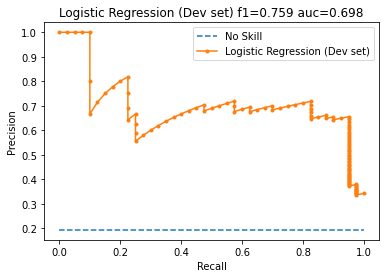

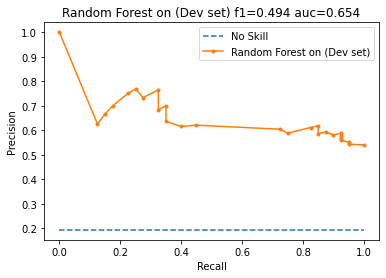

In [47]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_std, y_train)
plot_precision_recall_curve(lr_model, X_dev_std, y_dev, 'Logistic Regression (Dev set)')


rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
plot_precision_recall_curve(rf_model, X_dev_std, y_dev, 'Random Forest on (Dev set)')

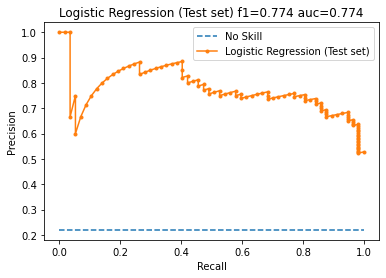

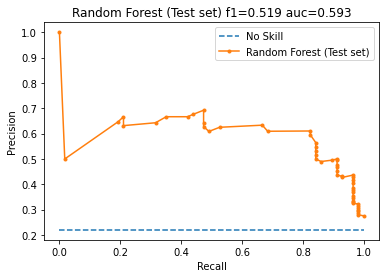

In [48]:
lr_pr_thresholds = plot_precision_recall_curve(lr_model, X_test_std, y_test, 'Logistic Regression (Test set)', return_thresholds=True)

rf_pr_thresholds = plot_precision_recall_curve(rf_model, X_test_std, y_test, 'Random Forest (Test set)', return_thresholds=True)

### XGBoost Model

In [22]:
base_xgb_model = XGBClassifier(tree_method='hist', seed = 0)

params = { 'objective': ['binary:logistic'],
           'max_depth': [6, 9, 12],
           'learning_rate': [0.01, 0.1],
           'subsample': np.arange(0.5, 1.0, 0.2),
           'colsample_bytree': np.arange(0.4, 1.0, 0.2),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
           'n_estimators': [100, 200, 500]}

rcv = RandomizedSearchCV(estimator=base_xgb_model,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=100,
                         cv=5,
                         verbose=2)

rcv.fit(X_train_dev_std, y_train_dev)

xgb_model = rcv.best_estimator_
print('Best hyper parameters: ', rcv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.9s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.6s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.5s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.7s
[CV] END colsample_bylevel=0.60000000

[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.1, max_depth=12, n_estimators=100, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.8000000000000002, learning_rate=0.1, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.7; total time=   0.3s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.8000000000000002, learning_rate=0.1, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.7; total time=   0.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.8000000000000002, learning_rate=0.1, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.7; total time=   0.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.8000000000000002, learning_rate=0.1, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.7; total time=   0.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.8000000000000002, learning_rate=0

[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.5s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.6s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.6s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.7s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=100, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.6s
[CV] END colsample_b

[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.3s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.4s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.4s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   1.4s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   1.6s
[CV] END colsample_bylevel=0.600000

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.7s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   1.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   1.8s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.1s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0

[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.1, max_depth=12, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.4s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.1, max_depth=12, n_estimators=100, objective=binary:logistic, subsample=0.5; total time=   0.4s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.7; total time=   2.7s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.7; total time=   3.0s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.7; total time=   2.8s
[CV] END colsample_bylevel=0.8000000000000002, col

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.2s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.2s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.5s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.7s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.2s
[CV] END colsample_bylevel=0.4, colsample_bytree=0

[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.9s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.7s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.7s
[CV] END colsample_bylevel=0.6000000000000001, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.9s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   2.0s
[CV] END colsample_b

[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.6s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.6s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.7s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   1.6s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.8000000000000002, learning_rate=0.01, max_depth=6, n_estimators=500, objective=binary:logistic, subsample=0.5; total time=   1.6s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.80

[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.6s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.6s
[CV] END colsample_bylevel=0.4, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic, subsample=0.8999999999999999; total time=   0.7s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=12, n_estimators=500, objective=binary:logistic, subsample=0.7; total time=   2.2s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=12, n_estimators=500, objective=binary:logistic, subsample=0.7; total time=   2.3s
[CV] END colsample_bylevel=0.8000000000000002, cols

[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.1s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.2s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.4s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.5s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.4, learning_rate=0.01, max_depth=9, n_estimators=500, objective=binary:logistic, subsample=0.8999999999999999; total time=   2.5s
[CV] END colsample_b

[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.7s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.1, max_depth=12, n_estimators=200, objective=binary:logistic, subsample=0.7; total time=   0.9s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   1.0s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.7s
[CV] END colsample_bylevel=0.8000000000000002, colsample_bytree=0.6000000000000001, learning_rate=0.01, max_depth=9, n_estimators=200, objective=binary:logistic, subsample=0.5; total time=   0.8s
[CV] END colsample_b

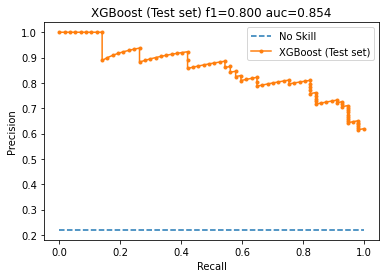

In [46]:
xgb_pr_thresholds = plot_precision_recall_curve(xgb_model, X_test_std, y_test, 'XGBoost (Test set)', return_thresholds=True)

In [44]:
feature_importance_df = pd.DataFrame(zip(feature_names, xgb_model.feature_importances_), columns = ['feature_name','feature_importance']).sort_values('feature_importance',ascending=False).reset_index(drop=True)

In [45]:
feature_importance_df

,feature_name,feature_importance
0,confidence__max,0.243931
1,area_in_meters__min,0.243488
2,esalc__bare,0.133955
3,fb_road_0-50,0.094631
4,esalc__built,0.079264
5,osm_road_0-50,0.047594
6,esalc__forest,0.020190
7,esalc__grassland,0.018637
8,fb_road_500-50,0.017939
9,esalc__cropland,0.015305
